<a href="https://colab.research.google.com/github/FaiazS/Diffusion-based-Image-Generation-with-U-Net/blob/main/Diffusion_based_Image_Generation_with_U_Net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forward Diffusion Process of a Diffusion Model**

In [1]:
#Importing the required Libraries

import torch

import torchvision.transforms as transforms

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

In [2]:
#Load the Image and convert it into a Tensor

image_path = "/content/Images/FaiazDiffusion.jpg"

image = Image.open(image_path).convert("RGB")

convert_image = transforms.Compose([transforms.Resize((256,256), interpolation=Image.BILINEAR), transforms.ToTensor(),])

tensored_image = convert_image(image) #(Number of Channels, Height, Width)

In [3]:
#Defining Noise(Random Data) Schedule and the Function to add Noise(Random Data) on the Top of the Image.

T = 1000 #Number of diffusion steps

alphas = torch.linspace(1, 0, T)

alphas_cumulative_product = torch.cumprod(alphas, dim = 0)

def forward_diffusion(x0, T):

  noise = torch.randn_like(tensored_image)  #Generating Random Gaussian Noise of the same Shape as x0

  xt = torch.sqrt(alphas_cumulative_product[T]) * tensored_image + torch.sqrt(1 - alphas_cumulative_product[T]) * noise

  return noise, xt

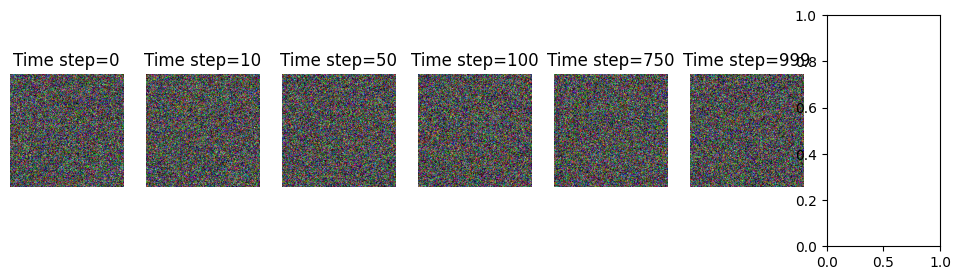

In [4]:
#Displaying the Image at Different Noise (Random Data) levels

fig, axes = plt.subplots(1, 7, figsize = (12, 3))

for idx, time_step in enumerate([0, 10, 50, 100, 750, 999]):  #Different time steps

  xt, _ = forward_diffusion(tensored_image, time_step)

  axes[idx].imshow(xt.permute(1, 2, 0).numpy())

  axes[idx].set_title(f"Time step={time_step}")

  axes[idx].axis("off")

plt.show()

In [5]:
#Defining the U-Net Neural Network Model and initializing Training


import torch

import torch.nn as nn

import torch.optim as optim


#Defining the U-Net Architecture

class UNet(nn.Module):

  def __init__(self):

    super().__init__()

    self.encoder = nn.Sequential(

                                 nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),

                                 nn.ReLU(),

                                 nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),  #Down-Sampling

                                 nn.ReLU()
    )


    self.bottleneck = nn.Sequential(

                                    nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),

                                    nn.ReLU()
    )

    self.decoder = nn.Sequential(

                                 nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1),  #Up-Sampling

                                 nn.ReLU(),

                                 nn.Conv2d(64, 3, kernel_size = 3, stride = 1, padding = 1),

                                 nn.Tanh() # Output should be between (-1 to 1)
    )


  def forward(self, x):

   x = self.encoder(x)

   x = self.bottleneck(x)

   x = self.decoder(x)

   return x


#Defining the Loss Function and Optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

u_net_model = UNet().to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(u_net_model.parameters(), lr = 0.001)


#Training process

def train(tensored_image, number_of_epochs = 77):

    for epoch in range(number_of_epochs):

      time_step = torch.randint(0, T, (1,)).item()

      xt, noise = forward_diffusion(tensored_image, time_step)  # Add noise(Random data) over the Image

      optimizer.zero_grad()

      predicted_noise = u_net_model(xt.unsqueeze(0).to(device)) #Predict Noise

      predicted_noise = transforms.Resize((noise.shape[1], noise.shape[2]))(predicted_noise)

      loss = criterion(predicted_noise, noise.unsqueeze(0).to(device))

      loss.backward()

      optimizer.step()

      print(f"Epoch {epoch + 1}/{number_of_epochs} , Loss : {loss.item()}")

train(tensored_image)

Epoch 1/77 , Loss : 1.0023866891860962
Epoch 2/77 , Loss : 0.9951250553131104
Epoch 3/77 , Loss : 0.9803497791290283
Epoch 4/77 , Loss : 0.9510471224784851
Epoch 5/77 , Loss : 0.9252972602844238
Epoch 6/77 , Loss : 0.8797096610069275
Epoch 7/77 , Loss : 1.0444499254226685
Epoch 8/77 , Loss : 0.8554379343986511
Epoch 9/77 , Loss : 0.8541848063468933
Epoch 10/77 , Loss : 0.5955687165260315
Epoch 11/77 , Loss : 0.8865211606025696
Epoch 12/77 , Loss : 0.28090301156044006
Epoch 13/77 , Loss : 0.9160280823707581
Epoch 14/77 , Loss : 0.9064767956733704
Epoch 15/77 , Loss : 0.8798999786376953
Epoch 16/77 , Loss : 0.8433634638786316
Epoch 17/77 , Loss : 0.8029773831367493
Epoch 18/77 , Loss : 0.7707397937774658
Epoch 19/77 , Loss : 0.7525026202201843
Epoch 20/77 , Loss : 0.7322530150413513
Epoch 21/77 , Loss : 0.6982555389404297
Epoch 22/77 , Loss : 0.6683983206748962
Epoch 23/77 , Loss : 0.6293230652809143
Epoch 24/77 , Loss : 0.6194508671760559
Epoch 25/77 , Loss : 0.2784654200077057
Epoch 26

**Reverse Diffusion Process of a diffusion model**

In [6]:
def reverse_diffusion(model, TIME_STEPS = 1000):

  with torch.no_grad():

    x_t = torch.randn((1, 3, 256, 256), device = device)  #Starting with pure Noise

    for time_step in reversed(range(TIME_STEPS)):

      predicted_noise = model(x_t) #Noise prediction

      predicted_noise = transforms.Resize((x_t.shape[2], x_t.shape[3]))(predicted_noise)

      alpha_timestep = alphas_cumulative_product[time_step]

      #Correct Denoising formula

      x_t = (x_t - (1 - alpha_timestep) * predicted_noise) / torch.sqrt(alpha_timestep)

      x_t = torch.clamp(x_t, -1, 1) #Ensuring output values is in range (-1 to 1)

      if time_step % 100 == 0:  # Display every 100 time steps

           plt.imshow(((x_t.squeeze().permute(1, 2, 0) + 1) / 2).cpu().numpy())  #Scaling to 0 to 1

           plt.title(f"Time step={time_step}")

           plt.axis("off")

           plt.show()


  return x_t

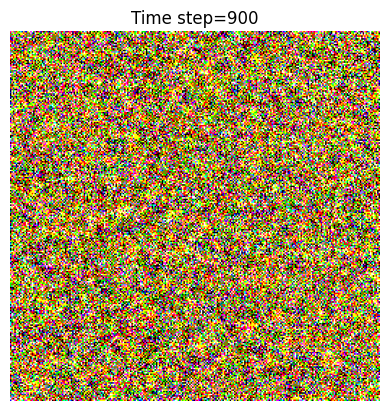

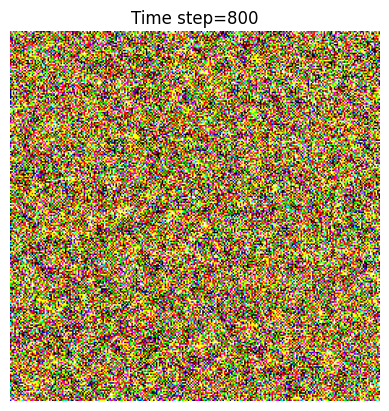

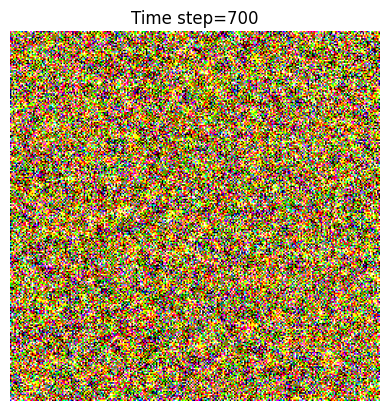

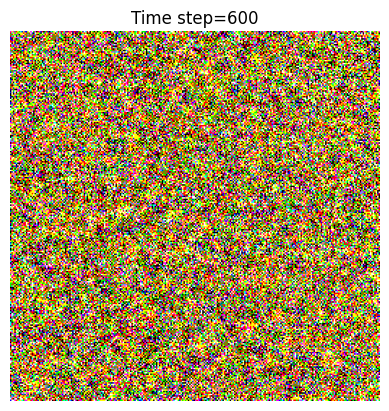

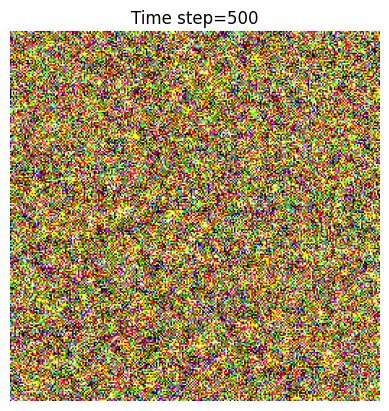

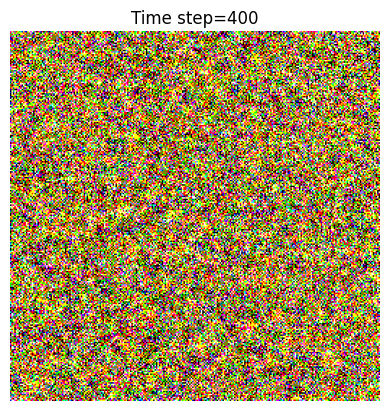

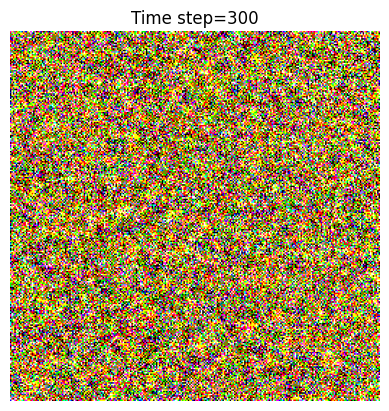

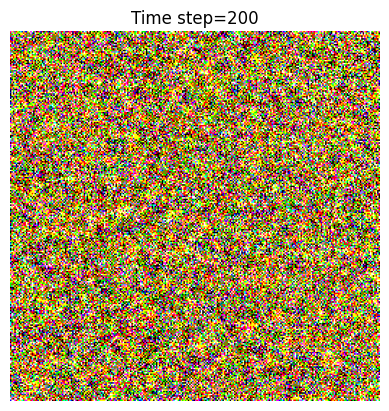

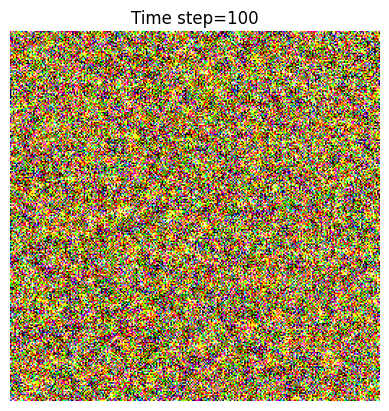

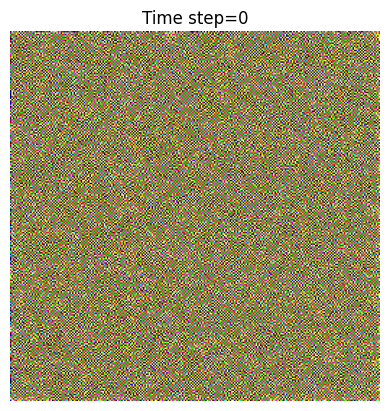

In [7]:
generate_image = reverse_diffusion(u_net_model)